In [1]:
# For data generation
import sys
# !{sys.executable} -m pip install xgboost --upgrade
import shutil
import os
import numpy as np
from glob import glob
import re
import pandas as pd
import pickle
#random
from time import perf_counter

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV


#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 


from tqdm.auto import tqdm
# from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
with open('test_ind.pickle', 'rb') as handle:
    test_ind = pickle.load(handle)

with open('train_ind.pickle', 'rb') as handle:
    train_ind = pickle.load(handle)
    
print(len(train_ind),len(test_ind))    


38 38


In [3]:
# feat_name=['From_Same_Orbital', 'pair_energy', 'coulomb', 'screen1_1', 'screen1_2',
#        'screen1_3', 'screen1_4', 'screen2_1', 'screen2_2', 'screen2_3',
#        'screen2_4', 'eijab_1', 'eijab_2', 'eijab_3', 'eijab_4', 'screenvirt_1',
#        'screenvirt_2', 'screenvirt_3', 'screenvirt_4', 'Fr1', 'Fr2', 'Fr3',
#        'Fr4', 'Fs1', 'Fs2', 'Fs3', 'Fs4', 'occr1', 'occr2', 'occr3', 'occr4',
#        'occs1', 'occs2', 'occs3', 'occs4', 'SCFFr1', 'SCFFr2', 'SCFFr3',
#        'SCFFr4', 'SCFFs1', 'SCFFs2', 'SCFFs3', 'SCFFs4', 'SCFOCCr1',
#        'SCFOCCr2', 'SCFOCCr3', 'SCFOCCr4', 'SCFOCCs1', 'SCFOCCs2', 'SCFOCCs3',
#        'SCFOCCs4', 'hrr1', 'hrr2', 'hrr3', 'hrr4', 'hss1', 'hss2', 'hss3',
#        'hss4', 'hpp', 'hqq', 'Fp', 'Fq', 'occp', 'occq', 'SCFFp', 'SCFFq',
#        'SCFOCCp', 'SCFOCCq']

# feat_name=['occs3',
#  'SCFOCCs2',
#  'SCFOCCs1',
#  'screen2_1',
#  'SCFOCCp',
#  'hss4',
#  'hrr1',
#  'Fs2',
#  'occq',
#  'screenvirt_4',
#  'SCFFs2',
#  'hrr3',
#  'SCFFr1',
#  'screenvirt_2',
#  'screenvirt_3',
#  'SCFFs4',
#  'hss2',
#  'screen1_2',
#  'hrr4',
#  'screen1_3',
#  'Fp',
#  'Fr1',
#  'screenvirt_1',
#  'occs4',
#  'screen2_4',
#  'SCFFr2',
#  'eijab_2',
#  'screen2_3',
#  'SCFFs1',
#  'eijab_4',
#  'Fq',
#  'hss1',
#  'SCFFr4',
#  'occs2',
#  'occp',
#  'screen1_4',
#  'eijab_1',
#  'hpp',
#  'pair_energy',
#  'hrr2',
#  'hqq',
#  'SCFFr3',
#  'occs1',
#  'Fr2',
#  'eijab_3',
#  'SCFOCCq',
#  'SCFOCCs4',
#  'Fs3',
#  'Fs1',
#  'From_Same_Orbital',
#  'hss3',
#  'Fs4',
#  'SCFOCCs3',
#  'Fr4',
#  'screen2_2',
#  'screen1_1',
#  'Fr3',
#  'SCFFs3']

feat_name=['SCFFs3',
 'hrr3',
 'screen1_1',
 'SCFOCCs2',
 'hpp',
 'SCFOCCs3',
 'hss4',
 'screen2_2',
 'SCFOCCq',
 'hss1',
 'screenvirt_3',
 'SCFFs4',
 'SCFFr4',
 'SCFOCCs1',
 'SCFFr3',
 'hss2',
 'screen2_4',
 'screenvirt_2',
 'SCFFs2',
 'hss3',
 'hqq',
 'hrr4',
 'hrr1',
 'screen1_3',
 'SCFOCCs4',
 'SCFFr1',
 'SCFFs1',
 'hrr2',
 'SCFFr2',
 'screen1_4',
 'screen2_1',
 'screenvirt_1',
 'screen1_2',
 'SCFOCCp',
 'screen2_3',
 'screenvirt_4']


In [4]:
# Xcheck=pd.DataFrame(np.vstack([np.vstack(train_X),np.vstack(test_X)]),columns=feat_name)

In [5]:
train_X=[]
train_y = []

test_X=[]
test_y = []

nam='O3/fixed_feats.pickle'
trydf=pd.read_pickle(nam).astype(float)[feat_name]    
trydf.index.set_levels([int(i.split('/')[1].split('_')[1]) for i in trydf.index.levels[0]], level=0,inplace=True)
# for nam in sorted(glob('*/fixed_feats.pickle'),key=lambda x: int(x.split('_')[0].strip('H')))[2:]:
for i in train_ind:
    train_X.append(trydf.loc[int(i)].values)
for j in test_ind: 
    test_X.append(trydf.loc[int(j)].values)
    
    
# This recover is wrong... did not account for the # of pair-energies     
recover_train=[]    
recover_test=[]    
tst_idx=0
tr_idx=0
for nidx,nam in enumerate(glob('*/fixed_targets.pickle')):
    trydf=pd.read_pickle(nam).astype(float)
    Hnam=nam.split('/')[0].split('_')[0]
    for tridx,i in enumerate(train_ind):
        pairdf=trydf[f'{int(i)}'].values
        train_y.append(pairdf)
        for k in range(len(pairdf)):
            recover_train.append((int(i),tridx,tr_idx))
            tr_idx+=1
        
    for teidx,j in enumerate(test_ind): 
        pairdf=trydf[f'{int(j)}'].values
        test_y.append(pairdf)        
        
        for k in range(len(pairdf)):
            recover_test.append((int(j),teidx,tst_idx))
            tst_idx+=1


<ipython-input-5-c9941cb056c0>:9: FutureWarning: inplace is deprecated and will be removed in a future version.
  trydf.index.set_levels([int(i.split('/')[1].split('_')[1]) for i in trydf.index.levels[0]], level=0,inplace=True)


In [6]:
X_train, X_test=np.vstack(train_X).astype(float),np.vstack(test_X).astype(float)
for u,v in np.argwhere(np.isnan(X_train)):
    X_train[u,v]=0
    
for u,v in np.argwhere(np.isnan(X_test)):
    X_test[u,v]=0    

In [7]:
y_train,y_test=np.hstack(train_y).astype(float),np.hstack(test_y).astype(float)

In [8]:
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [9]:
print(X_train.shape,X_test.shape)

(3572, 36) (3572, 36)


In [10]:
from xgboost import XGBRegressor
# model=XGBRegressor(reg_lambda=0.3,max_depth=100,min_child_weight=5)
# model=XGBRegressor(max_depth=100,min_child_weight=1,n_estimators=100, reg_alpha=0.001, reg_lambda=0.001)
# model.fit(X_train,y_train)
# y_pred_train=model.predict(X_train)
# y_pred_test=model.predict(X_test)
# print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
# print(f"RMSE (mEh): {mean_squared_error(y_train,y_pred_train,squared=False)*1e3:.4f},{mean_squared_error(y_test,y_pred_test,squared=False)*1e3:.4f}")

params = {'max_depth': [1, 10, 100],
#           'n_estimators': [100, 500, 1000],
          'reg_lambda': [1e-6, 1e-3,1e-1],
          'reg_alpha': [1e-6, 1e-3,1e-1]}

model = XGBRegressor()
grid = GridSearchCV(estimator=model, 
                   param_grid=params,
                   scoring='r2', 
                   verbose=1000,n_jobs=12).fit(X_train,y_train)


gmodel=grid.best_estimator_
y_pred_train=gmodel.predict(X_train)
y_pred_test=gmodel.predict(X_test)
print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
print(f"RMSE (mEh): {mean_squared_error(y_train,y_pred_train,squared=False)*1e3:.4f},{mean_squared_error(y_test,y_pred_test,squared=False)*1e3:.4f}")



Fitting 5 folds for each of 27 candidates, totalling 135 fits
R2: 0.9579,0.9299
RMSE (mEh): 2.4337,3.1503


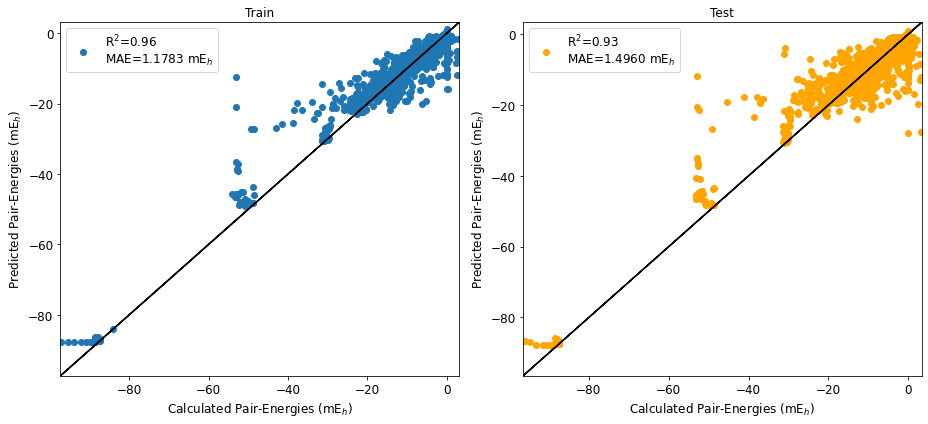

In [11]:
font=12
plt.rc('font', size=font)          # controls default text sizes
plt.rc('axes', titlesize=font)     # fontsize of the axes title
plt.rc('axes', labelsize=font)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font)    # fontsize of the tick labels
plt.rc('legend', fontsize=font)    # legend fontsize
plt.rc('figure', titlesize=font)  # fontsize of the figure title
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(13,6))
scale=1e-1
ax1.set_title('Train')
ax1.scatter(1e3*y_train,1e3*y_pred_train,label="R$^{2}$="+f'{r2_score(y_train,y_pred_train):.2f}\nMAE={1e3*mean_absolute_error(y_train,y_pred_train):.4f}'+" mE$_{h}$")
ax1.plot(1e3*y_train,1e3*y_train,'k-')
ax1.set_xlim(1e3*min(y_train)-scale,1e3*max(y_train)+scale)
ax1.set_ylim(1e3*min(y_train)-scale,1e3*max(y_train)+scale)
ax1.set_xlabel('Calculated Pair-Energies (mE$_{h}$)')
ax1.set_ylabel('Predicted Pair-Energies (mE$_{h}$)')
ax1.legend()


ax2.set_title('Test')
ax2.scatter(1e3*y_test,1e3*y_pred_test,label="R$^{2}$="+f'{r2_score(y_test,y_pred_test):.2f}\nMAE={1e3*mean_absolute_error(y_test,y_pred_test):.4f}'+" mE$_{h}$",color='orange')
ax2.plot(1e3*y_test,1e3*y_test,'k-')
ax2.set_xlim(1e3*min(y_test)-scale,1e3*max(y_test)+scale)
ax2.set_ylim(1e3*min(y_test)-scale,1e3*max(y_test)+scale)
ax2.set_xlabel('Calculated Pair-Energies (mE$_{h}$)')
ax2.set_ylabel('Predicted Pair-Energies (mE$_{h}$)')
ax2.legend()
if os.path.exists('images')==False:
    os.mkdir('images')
plt.tight_layout()
plt.savefig('images/O3_parity.png',dpi=300,bbox_inches='tight')
plt.show()

In [13]:
testdct=[np.vstack((y_test[np.array(recover_test)[np.array(recover_test)[:,1].astype(int)==i][:,2].astype(int)],y_pred_test[np.array(recover_test)[np.array(recover_test)[:,1].astype(int)==i][:,2].astype(int)])) for i in np.unique(np.array(recover_test)[:,1].astype(int))]

test_errors=mean_absolute_error(np.hstack(testdct)[0],np.hstack(testdct)[1])*1e3

In [14]:
traindct=[np.vstack((y_train[np.array(recover_train)[np.array(recover_train)[:,1].astype(int)==i][:,2].astype(int)],y_pred_train[np.array(recover_train)[np.array(recover_train)[:,1].astype(int)==i][:,2].astype(int)])) for i in np.unique(np.array(recover_train)[:,1].astype(int))]

train_errors=mean_absolute_error(np.hstack(traindct)[0],np.hstack(traindct)[1])*1e3

In [23]:
CASSCF=pd.concat([pd.read_csv(i,index_col=1).drop(columns=['Unnamed: 0']).rename(columns={'energy':i.split('_')[0]}) for i in glob('*/CASSCF.csv')],axis=1)
CASPT2=pd.concat([pd.read_csv(i,index_col=1).drop(columns=['Unnamed: 0']).rename(columns={'energy':i.split('_')[0]}) for i in glob('*/CASPT2.csv')],axis=1)
E2=pd.concat([pd.read_csv(i,index_col=1).drop(columns=['Unnamed: 0']).rename(columns={'energy':i.split('_')[0]}) for i in glob('*/E2.csv')],axis=1)    

# CASSCF.index=[f'{int(i)}' for i in CASSCF.index]
# CASPT2.index=[f'{int(i)}' for i in CASPT2.index]
# E2.index=[f'{int(i)}' for i in E2.index]

array([107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131,
       133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157,
       159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181])

In [16]:
pairedcp=sns.color_palette('Paired')

In [27]:
test_E2={np.unique(np.array(recover_test)[:,0])[idx]:{'true':sum(u),'pred':sum(v)} for idx,(u,v) in enumerate(testdct)}
train_E2={np.unique(np.array(recover_train)[:,0])[idx]:{'true':sum(u),'pred':sum(v)} for idx,(u,v) in enumerate(traindct)}

<Axes: xlabel='true', ylabel='pred'>

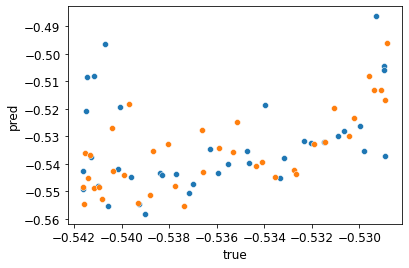

In [39]:
sns.scatterplot(data=pd.DataFrame.from_dict(test_E2).T,x='true',y='pred')
sns.scatterplot(data=pd.DataFrame.from_dict(train_E2).T,x='true',y='pred')